**Import Brain Invader Library**

In [1]:
from braininvaders2015a.dataset import BrainInvaders2015a

import pandas as pd
import numpy as np

**Import Invader Dataset**

In [2]:
dataset = BrainInvaders2015a()

def loadData(subject, session = 'session_1', run = 'run_1'):
    data = dataset._get_single_subject_data(subject)
    data = data[session][run]
    # data.set_montage(ten_twenty_montage)
    return data

data_subjects = []
subjects = list(range(1,44))
# subjects.remove(1)
# subjects.remove(27)

for subject in subjects:
    data_subjects.append(loadData(subject))

# Preprocessing

**Preprocessing Functions**

In [3]:
import mne
from mne import create_info
from mne import Epochs, find_events

from sklearn.decomposition import PCA

def df_to_raw(df):
    sfreq = 512
    ch_names = list(df.columns)
    ch_types = ['eeg'] * (len(df.columns) - 1) + ['stim']
    ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')

    df = df.T
      #mne looks at the tranpose() format
    df[:-1] *= 1e-6
      #convert from uVolts to Volts (mne assumes Volts data)

    info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

    raw = mne.io.RawArray(df, info)
    raw.set_montage(ten_twenty_montage)
    return raw

def getEpochs(raw, event_id, tmin, tmax, picks):

    #epoching
    events = find_events(raw)
    
    #reject_criteria = dict(mag=4000e-15,     # 4000 fT
    #                       grad=4000e-13,    # 4000 fT/cm
    #                       eeg=100e-6,       # 150 μV
    #                       eog=250e-6)       # 250 μV

    reject_criteria = dict(eeg=100e-6)  #most voltage in this range is not brain components

    epochs = Epochs(raw, events=events, event_id=event_id, 
                    tmin=tmin, tmax=tmax, baseline=None, preload=True,verbose=False, picks=picks)  #8 channels
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)

    return epochs
  
def preprocessing(rawdata, runPCA=False):
    # Convert and drop time column
    data_ses1_run1_pd = rawdata.to_data_frame()
    data_ses1_run1_pd = data_ses1_run1_pd.drop(['time'],axis = 1)
    raw = df_to_raw(data_ses1_run1_pd)

    # Notch Filter
    raw.notch_filter(np.arange(50, 251, 50))

    eeg_channels = mne.pick_types(raw.info, eeg=True)
    raw.filter(1,24,method = 'iir')


    if runPCA:
        raw_df = raw.to_data_frame()
        X1 = raw_df.drop(['time'],axis = 1)
        X = X1.drop(['STI 014'],axis = 1)
        y = raw_df['STI 014']
        pca = PCA(n_components=32)
        X = pca.fit(X.values).transform(X.values)
        y1 = y.values.reshape(-1,1)
        data = np.hstack((X,y1))
        df = pd.DataFrame(data, columns = list(X1.columns))
        raw = df_to_raw(df)

    event_id = {'NonTarget': 1, 'Target': 2}
    tmin = 0.0 #0
    tmax = 1.0 #0.5 seconds
    picks= eeg_channels
    epochs = getEpochs(raw,event_id, tmin, tmax, picks)

    X = epochs.get_data()
    y = epochs.events[:, -1]
    return X, y

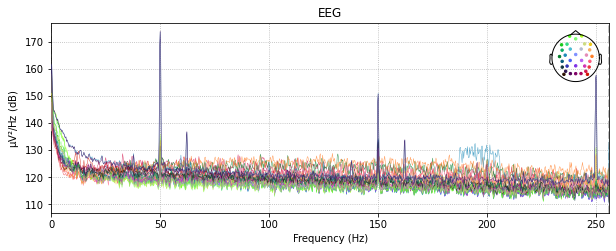

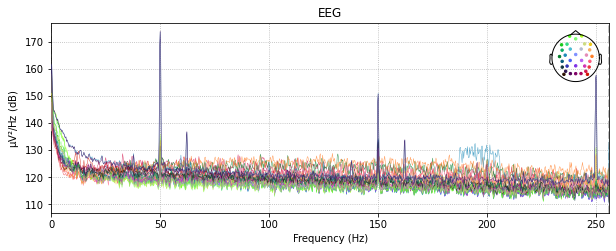

In [4]:
ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')     #'standard_1020' -> Electrodes are named and positioned according to the international 10-20 system
data_subjects[2].set_montage(ten_twenty_montage)
data_subjects[2].plot_psd()

**Preprocessing Data**

In [5]:
from IPython.display import clear_output

X_subjects = []
y_subjects = []
runPCA = False

for data in data_subjects:
    X, y = preprocessing(data, runPCA=runPCA)    
    X_subjects.append(X)
    y_subjects.append(y)
    clear_output(wait=True)

Creating RawArray with float64 data, n_channels=33, n_times=129472
    Range : 0 ... 129471 =      0.000 ...   252.873 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 24.00 Hz: -6.02, -6.02 dB

360 events found
Event IDs: [1 2]
sample drop %:  0.0


In [6]:
X.shape

(360, 32, 513)

In [7]:
y.shape

(360,)

In [8]:
# raw_subject2 = np.concatenate((X, y), axis=2)
# raw_subject2.shape

**Convert Data**

**Import torch**

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset

**Reshape Data, Convert to torch, Test/Train Split and Data Loader**

In [10]:
# Define dataset
def ShapePreparing(X, y, BATCH_SIZE = 32):
    X_reshaped = X[:, np.newaxis, :, :]
    torch_X_reshaped = torch.from_numpy(X_reshaped)
    torch_y = torch.from_numpy(y)

    ds = TensorDataset(torch_X_reshaped, torch_y)

    #Train test split
    train_size = int(round(torch_X_reshaped.size()[0] * 0.7))
    valid_size = int(round(torch_X_reshaped.size()[0] * 0.1))
    test_size = int(round(torch_X_reshaped.size()[0] * 0.2))
    sum_size = np.sum([train_size, valid_size, test_size])

    while sum_size<torch_X_reshaped.shape[0]:
        train_size += 1
        sum_size = np.sum([train_size, valid_size, test_size])
    while sum_size>torch_X_reshaped.shape[0]:
        train_size -= 1
        sum_size = np.sum([train_size, valid_size, test_size])
        
    train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])

     
    #Train set loader
    train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True)
    #Validation set loader
    valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True)

    #Test set loader
    test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                            batch_size=BATCH_SIZE, 
                                            shuffle=True)
    return train_iterator, valid_iterator, test_iterator

train_iterator, valid_iterator, test_iterator = ShapePreparing(X, y, BATCH_SIZE=32)

In [11]:
#Check train_iterator
for i, (images, labels) in enumerate(train_iterator):
    print(images.shape)
print(i)

torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([28, 1, 32, 513])
7


In [12]:
#Check valid_iterator
for i, (images, labels) in enumerate(valid_iterator):
    print(images.shape)
print(i)

torch.Size([32, 1, 32, 513])
torch.Size([4, 1, 32, 513])
1


In [13]:
#Check test_iterator
for i, (images, labels) in enumerate(test_iterator):
    print(images.shape)
print(i)

torch.Size([32, 1, 32, 513])
torch.Size([32, 1, 32, 513])
torch.Size([8, 1, 32, 513])
2


# Model

**Conv2D: Parallel CNN**

In [14]:
# Convolutional neural network (two convolutional layers)
class Conv2D(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self, num_classes=10):
        super(Conv2D, self).__init__()
        
        #using sequential helps bind multiple operations together
        #layer1 = input shape [batch size=32, channels=1, height=32, width=500]
        
        self.layer2 = nn.Sequential(
            #in_channel = 1
            #out_channel = 20
            #kernel_size = (32,1)
            nn.Conv2d(1, 20, kernel_size=(32,1), stride=(1,1)))
            #after layer2 will be of shape [batch size=32, channels=20, height=1, width=500]
            
        self.layer3_1 = nn.Sequential(
            #in_channel = 20
            #out_channel = 16
            #kernel_size = (1,5)
            nn.Conv2d(20, 16, kernel_size=(1,5), stride=(1,5)),nn.ReLU())
    
        self.layer3_2 = nn.Sequential(
            #in_channel = 20
            #out_channel = 16
            #kernel_size = (1,10)
            nn.Conv2d(20, 16, kernel_size=(1,10), stride=(1,10)),nn.ReLU())
            #after layer3_1 will be of shape [batch size=32, channels=16, height=1, width=50]
        
        self.layer3_3 = nn.Sequential(
            #in_channel = 20
            #out_channel = 16
            #kernel_size = (1,20)
            nn.Conv2d(20, 16, kernel_size=(1,20), stride=(1,20)),nn.ReLU())
            #after layer3_1 will be of shape [batch size=32, channels=16, height=1, width=25]
            
        #after concatenate (layer3_1,layer3_2,layer3_3) will be of shape [batch size=32, channels=16, height=1, width=175]
        self.layer4 = nn.Sequential(nn.Dropout(0.1),nn.ReLU())
        #after layer4 will be of shape [batch size=32, channels=16, height=1, width=175]
        
        self.layer5_1 = nn.Sequential(
            #in_channel = 16
            #out_channel = 16
            #kernel_size = (1,5)
            nn.Conv2d(16, 16, kernel_size=(1,5), stride=(1,5)),nn.ReLU())
            #after layer5_1 will be of shape [batch size=32, channels=16, height=1, width=35]
            
        self.layer5_2 = nn.Sequential(
            #in_channel = 16
            #out_channel = 16
            #kernel_size = (1,7)
            nn.Conv2d(16, 16, kernel_size=(1,7), stride=(1,7)),nn.ReLU())
            #after layer5_2 will be of shape [batch size=32, channels=16, height=1, width=25]
            
        self.layer5_3 = nn.Sequential(
            #in_channel = 16
            #out_channel = 16
            #kernel_size = (1,25)
            nn.Conv2d(16, 16, kernel_size=(1,25), stride=(1,25)),nn.ReLU())
            #after layer5_3 will be of shape [batch size=32, channels=16, height=1, width=7]
            
        #after concatenate (layer5_1,layer5_2,layer5_3) will be of shape [batch size=32, channels=16, height=1, width=67]
        self.layer6 = nn.Sequential(nn.Dropout(0.1),nn.ReLU())
        #after layer6 will be of shape [batch size=32, channels=16, height=1, width=67]
        
        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size=(1,2), stride=(1,2)), nn.ReLU())
        #after layer7 will be of shape [batch size=32, channels=16, height=1, width=33]
        
        self.fc = nn.Sequential(nn.Linear(528,100),nn.ReLU(),
                               nn.Linear(100,50),
                               nn.Linear(50,3))
        #after fully connected will be of shape [batch size=32, 3] 
        
#         self.softmax = nn.LogSoftmax(dim=1)
    
        
    def forward(self, x):
        #out shape: input shape [batch size=32, channels=1, height=32, width=500]
        out = self.layer2(x) #------------>[batch size=32, channels=20, height=1, width=500]

        out3_1 = self.layer3_1(out) #------->[batch size=32, channels=16, height=1, width=100]

        out3_2 = self.layer3_2(out) #------->[batch size=32, channels=16, height=1, width=50]

        out3_3 = self.layer3_3(out) #------->[batch size=32, channels=16, height=1, width=25]

        out = torch.cat((out3_1, out3_2, out3_3), dim=3)

        out = self.layer4(out) #------------>[batch size=32, channels=16, height=1, width=175]

        out5_1 = self.layer5_1(out) #------->[batch size=32, channels=16, height=1, width=35]

        out5_2 = self.layer5_2(out) #------->[batch size=32, channels=16, height=1, width=25]

        out5_3 = self.layer5_3(out) #------->[batch size=32, channels=16, height=1, width=7]

        out = torch.cat((out5_1, out5_2, out5_3), dim=3)

        out = self.layer6(out) #------------>[batch size=32, channels=16, height=1, width=67]

        out = self.layer7(out) #------------>[batch size=32, channels=16, height=1, width=33]

        out = out.flatten(start_dim = 1) #-->after squeezing: shape:[batch size=32, 16*1*33=528]
        out = self.fc(out) #---------------->after fully connected: shape:[batch size=32, 100]
#         print("out layer_fc: ",out.shape)
#         out = self.softmax(out)
#         print("out layer_softmax: ",out.shape)
        return out

**Define models and parameters**

In [15]:
learning_rate = 0.001
device = torch.device('cpu' if torch.cuda.is_available() else 'cuda')
print("Configured device: ", device)

model = Conv2D()
model = model.float()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device)
criterion = criterion.to(device)
print({type(model).__name__})

Configured device:  cpu
{'Conv2D'}


In [16]:
import time

def train(model, iterator, optimizer, criterion, _print=False):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []

    trues = []
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        if _print:
            print('================== Predicted y ====================')
            print(predicted)
        predicteds.append(predicted)
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        if _print:
            print('==================    True y   ====================')
            print(labels)
        trues.append(labels)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicteds, trues

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    predicteds = []
    trues = []
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicteds.append(predicted)
            trues.append(labels)
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator),predicteds, trues

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def saveModel(saveName, model, type_='Best'):
    directory = f'results/{type(model).__name__}/{type_}/'
    fileName = f'{saveName}.pth.tar'
    path = directory+fileName
    while True:
        try:
            torch.save(model.state_dict(), path)
            print("Model:{} saved.".format(fileName))
            break
        except:
            os.makedirs(directory)
            open(path, 'w')

**Train Fuction**

In [17]:
from IPython.display import clear_output
import os


def Training(model, train_iterator, valid_iterator, N_EPOCHS = 50, saveName=None):
    
    best_valid_loss = float('inf')
    best_epoch = 0

    train_losses = []
    valid_losses = []

    train_accs = []
    valid_accs = []
    
    start_time_train = time.time()

    for epoch in range(N_EPOCHS):

        train_loss, train_acc, train_pred_label, train_true_label = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_pred_label, valid_true_label= evaluate(model, valid_iterator, criterion)
        train_losses.append(train_loss); train_accs.append(train_acc)
        valid_losses.append(valid_loss); valid_accs.append(valid_acc)
        
        if (epoch+1) % 5 == 0:
            clear_output(wait=True)
            print("Trainning:", saveName)
            print(f'Epoch: [{epoch+1:02}/{N_EPOCHS}]')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            if saveName != None:
                saveModel(saveName, model, type_='Best')
    if saveName != None:
        saveModel(saveName, model, type_='Last')
    training_time = time.time() - start_time_train
    return train_losses, valid_losses, train_accs, valid_accs, training_time, best_epoch

**Train Data**

In [18]:
train_losses_list = []
train_accs_list = []
valid_losses_list = []
valid_accs_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
best_epoch_list = []
test_iterator_list = []

learning_rate = 0.001
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

start_time = time.time()

# for i in range(2):
for i in range(len(X_subjects)):
    # Split data
    train_iterator, valid_iterator, test_iterator = ShapePreparing(X_subjects[i], y_subjects[i], BATCH_SIZE=64)
    
    # Define model
    model = Conv2D()
    model = model.float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    criterion = criterion.to(device)
    
    # Training
    fname = "PCA" if runPCA else "woPCA"
    if subjects[i]<10:
        filename = f'{fname}_0{str(subjects[i])}'
    else:
        filename = f'{fname}_{str(subjects[i])}'
    # filename = None
    print(filename)
    train_losses, valid_losses, train_accs, valid_accs, training_time, best_epoch = Training(model, train_iterator, valid_iterator, N_EPOCHS = 50, saveName=filename)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator, criterion)
    # Record results
    train_losses_list.append(train_losses); train_accs_list.append(train_accs)
    valid_losses_list.append(valid_losses); valid_accs_list.append(valid_accs)
    test_loss_list.append(test_loss); test_acc_list.append(test_acc)
    training_time_list.append(training_time); best_epoch_list.append(best_epoch)
    test_iterator_list.append(test_iterator)
    
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Time using: {epoch_mins}m {epoch_secs}s')

Trainning: woPCA_43
Epoch: [50/50]
	Train Loss: 0.001 | Train Acc: 100.00%
	 Val. Loss: 0.148 |  Val. Acc: 94.44%
Model:woPCA_43.pth.tar saved.
Time using: 8m 59s


In [19]:
col = ["train_losses", "valid_losses", "test_loss", 
    "train_accs", "test_loss", "test_acc", 
    "training_time", "best_epoch"]
best_model_result = pd.DataFrame(columns=col, index=subjects)
last_model_result = pd.DataFrame(columns=col, index=subjects)

best_model_result.index.name = "subjects"

In [20]:
col = ["train_losses", "valid_losses", "test_loss", 
    "train_accs", "test_loss", "test_acc", 
    "training_time", "best_epoch"]
df = pd.DataFrame(columns=col, index=subjects)
df.index.name = "subjects"

for i in range(len(train_losses_list)):
    df.loc[subjects[i]] = [train_losses_list[i][-1], valid_losses_list[i][-1], test_loss_list[i], 
        train_accs_list[i][-1], valid_accs_list[i][-1], test_acc_list[i],
        training_time_list[i], best_epoch_list[i]]

df

,train_losses,valid_losses,test_loss,train_accs,test_loss,test_acc,training_time,best_epoch
subjects,,,,,,,,
1,0.01742,0.873355,1.137782,99.445061,82.4619,80.42436,55.415833,4
2,0.010874,1.557881,0.824746,100.0,76.595745,86.835106,10.880257,8
3,0.000473,0.002686,0.301908,100.0,100.0,88.194444,8.47974,43
4,0.013267,0.387742,0.674629,100.0,95.348837,87.354651,9.690295,41
5,0.010946,1.372745,0.466257,100.0,83.72093,87.936047,9.467103,7
6,0.000384,1.86054,1.336037,100.0,77.777778,86.342593,11.806281,3
7,0.000464,0.700504,0.519584,100.0,86.111111,80.815972,7.969089,14
8,0.007336,0.433476,0.476464,100.0,86.046512,91.242733,10.235578,8
9,0.000168,0.196889,0.936303,100.0,92.592593,91.001157,12.234093,42


In [21]:
df.to_csv("results\Conv2D\Conv2D_result.csv")

In [22]:
df.mean()

train_losses      0.006715
valid_losses      1.130575
test_loss         1.073156
train_accs       99.852387
test_loss        83.491811
test_acc         85.132367
training_time    12.516645
best_epoch       11.441860
dtype: float64

In [23]:
def trainedModelLoader(path, device):
    model = Conv2D()
    model.load_state_dict(torch.load(path))
    model.eval()
    model = model.float()
    criterion = nn.CrossEntropyLoss()
    model = model.to(device)
    criterion = criterion.to(device)
    return model, criterion

test_loss_best = []
test_acc_best = []
test_loss_last = []
test_acc_last = []

for i, subject in enumerate(subjects):
    fname = "PCA" if runPCA else "woPCA"
    if subject<10:
        filename = f'{fname}_0{str(subject)}'
    else:
        filename = f'{fname}_{str(subject)}'
    # Best model
    type_ = 'Best'
    path = f'results/Conv2D/{type_}/{filename}.pth.tar'
    model, criterion = trainedModelLoader(path, device)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator_list[i], criterion)
    test_loss_best.append(test_loss)
    test_acc_best.append(test_acc)
    # Last model
    type_ = 'Last'
    path = f'results/Conv2D/{type_}/{filename}.pth.tar'
    model, criterion = trainedModelLoader(path, device)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator_list[i], criterion)
    test_loss_last.append(test_loss)
    test_acc_last.append(test_acc)


print("==== Best model ====")
# print(test_acc_best)
print("max: ", np.max(test_acc_best))
print("min: ", np.min(test_acc_best))
print("mean: ", np.mean(test_acc_best))

print("==== Last (Load) model ====")
# print(test_acc_list)
print("max: ", np.max(test_acc_last))
print("min: ", np.min(test_acc_last))
print("mean: ", np.mean(test_acc_last))

print("==== Last model ====")
# print(test_acc_list)
print("max: ", np.max(test_acc_list))
print("min: ", np.min(test_acc_list))
print("mean: ", np.mean(test_acc_list))

==== Best model ====
max:  98.52430555555556
min:  74.21875
mean:  84.25744724561152
==== Last (Load) model ====
max:  95.52859042553192
min:  75.23777173913044
mean:  85.2356064434392
==== Last model ====
max:  96.30984042553192
min:  72.11277173913044
mean:  85.13236743304174


# With PCA

In [24]:
X_subjects = []
y_subjects = []
runPCA = True

for data in data_subjects:
    X, y = preprocessing(data, runPCA=runPCA)    
    X_subjects.append(X)
    y_subjects.append(y)
    clear_output(wait=True)

Creating RawArray with float64 data, n_channels=33, n_times=129472
    Range : 0 ... 129471 =      0.000 ...   252.873 secs
Ready.
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 24 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 24.00 Hz: -6.02, -6.02 dB

Creating RawArray with float64 data, n_channels=33, n_times=129472
    Range : 0 ... 129471 =      0.000 ...   252.873 secs
Ready.
360 events found
Event IDs: [1 2]
sample drop %: 

In [25]:
train_iterator, valid_iterator, test_iterator = ShapePreparing(X, y, BATCH_SIZE=32)

train_losses_list = []
train_accs_list = []
valid_losses_list = []
valid_accs_list = []
test_loss_list = []
test_acc_list = []
training_time_list = []
best_epoch_list = []
test_iterator_list = []

learning_rate = 0.001
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Configured device: ", device)

start_time = time.time()

# for i in range(2):
for i in range(len(X_subjects)):
    # Split data
    train_iterator, valid_iterator, test_iterator = ShapePreparing(X_subjects[i], y_subjects[i], BATCH_SIZE=32)
    
    # Define model
    model = Conv2D()
    model = model.float()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model = model.to(device)
    criterion = criterion.to(device)
    
    # Training
    fname = "PCA" if runPCA else "woPCA"
    if subjects[i]<10:
        filename = f'{fname}_0{str(subjects[i])}'
    else:
        filename = f'{fname}_{str(subjects[i])}'
    # filename = None
    print(filename)
    train_losses, valid_losses, train_accs, valid_accs, training_time, best_epoch = Training(model, train_iterator, valid_iterator, N_EPOCHS = 50, saveName=filename)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator, criterion)
    # Record results
    train_losses_list.append(train_losses); train_accs_list.append(train_accs)
    valid_losses_list.append(valid_losses); valid_accs_list.append(valid_accs)
    test_loss_list.append(test_loss); test_acc_list.append(test_acc)
    training_time_list.append(training_time); best_epoch_list.append(best_epoch)
    test_iterator_list.append(test_iterator)
    
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Time using: {epoch_mins}m {epoch_secs}s')

Trainning: PCA_43
Epoch: [50/50]
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.339 |  Val. Acc: 83.85%
Model:PCA_43.pth.tar saved.
Time using: 10m 18s


In [26]:
col = ["train_losses", "valid_losses", "test_loss", 
    "train_accs", "test_loss", "test_acc", 
    "training_time", "best_epoch"]
best_model_result = pd.DataFrame(columns=col, index=subjects)
last_model_result = pd.DataFrame(columns=col, index=subjects)

best_model_result.index.name = "subjects"

In [27]:
col = ["train_losses", "valid_losses", "test_loss", 
    "train_accs", "test_loss", "test_acc", 
    "training_time", "best_epoch"]
df = pd.DataFrame(columns=col, index=subjects)
df.index.name = "subjects"

for i in range(len(train_losses_list)):
    df.loc[subjects[i]] = [train_losses_list[i][-1], valid_losses_list[i][-1], test_loss_list[i], 
        train_accs_list[i][-1], valid_accs_list[i][-1], test_acc_list[i],
        training_time_list[i], best_epoch_list[i]]

df

,train_losses,valid_losses,test_loss,train_accs,test_loss,test_acc,training_time,best_epoch
subjects,,,,,,,,
1,0.016608,1.240851,1.496384,99.00111,82.643164,84.239754,62.591068,2
2,0.000082,1.610504,0.703469,100.0,82.114362,89.306294,11.746743,2
3,0.000124,0.747105,0.823373,100.0,91.145833,95.543981,8.508971,1
4,0.000074,0.89994,0.611054,100.0,87.936047,90.782461,10.14313,5
5,0.001918,1.629815,0.82209,100.0,82.485465,91.303295,10.10564,8
6,0.000056,0.868667,1.43303,100.0,85.706019,86.530671,12.837949,6
7,0.000133,1.419899,1.002239,100.0,89.756944,90.509259,9.006756,10
8,0.000218,0.314618,1.250098,100.0,86.373547,85.58624,10.623947,14
9,0.000247,0.489111,0.510729,100.0,89.756944,87.355324,12.774953,6


In [28]:
df.to_csv("results\Conv2D\Conv2D_PCA_result.csv")

In [29]:
df.mean()

train_losses      0.004366
valid_losses      1.034064
test_loss         1.056280
train_accs       99.900013
test_loss        85.359343
test_acc         86.438164
training_time    14.361696
best_epoch       10.325581
dtype: float64

In [30]:
test_loss_best = []
test_acc_best = []
test_loss_last = []
test_acc_last = []

for i, subject in enumerate(subjects):
    fname = "PCA" if runPCA else "woPCA"
    if subject<10:
        filename = f'{fname}_0{str(subject)}'
    else:
        filename = f'{fname}_{str(subject)}'
    # Best model
    type_ = 'Best'
    path = f'results/Conv2D/{type_}/{filename}.pth.tar'
    model, criterion = trainedModelLoader(path, device)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator_list[i], criterion)
    test_loss_best.append(test_loss)
    test_acc_best.append(test_acc)
    # Last model
    type_ = 'Last'
    path = f'results/Conv2D/{type_}/{filename}.pth.tar'
    model, criterion = trainedModelLoader(path, device)
    test_loss, test_acc, test_pred_label, test_true_label = evaluate(model, test_iterator_list[i], criterion)
    test_loss_last.append(test_loss)
    test_acc_last.append(test_acc)


print("==== Best model ====")
# print(test_acc_best)
print("max: ", np.max(test_acc_best))
print("min: ", np.min(test_acc_best))
print("mean: ", np.mean(test_acc_best))

print("==== Last (Load) model ====")
# print(test_acc_list)
print("max: ", np.max(test_acc_last))
print("min: ", np.min(test_acc_last))
print("mean: ", np.mean(test_acc_last))

print("==== Last model ====")
# print(test_acc_list)
print("max: ", np.max(test_acc_list))
print("min: ", np.min(test_acc_list))
print("mean: ", np.mean(test_acc_list))

==== Best model ====
max:  95.54398148148148
min:  65.04875886524822
mean:  85.00620034467495
==== Last (Load) model ====
max:  94.82371794871794
min:  72.38451086956522
mean:  85.8351991356636
==== Last model ====
max:  95.54398148148148
min:  76.00479014598541
mean:  86.43816365978707
